# Парсинг вакансий и анализ рынка труда для аналитиков данных

In [1]:
from selenium import webdriver
from selenium.webdriver import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

from datetime import datetime
from time import sleep

In [2]:
def convert_salary(salary_str):
    """
    # Парсинг границ зарплат, возвращает список (list)
    
    Parameters:
    -----------
    salary_str : str

    """

    usdrub = 76
    eurrub = 90    
    salary_num = []
    
    if salary_str == None:
        salary_num.append(None)
        salary_num.append(None)
        return(salary_num)        

    if "₽" in salary_str:
        rate = 1
        currency = "₽"
    elif "$" in salary_str:
        rate = usdrub       
        currency = "$"
    elif "€" in salary_str:
        rate = eurrub   
        currency = "€"
    else:
        salary_num.append(None)
        salary_num.append(None)
        return(salary_num)           
            
    salary_from_to = salary_str.split(currency)[0].replace(" ", "")

    tax_coef = 0.87 if "до вычет" in salary_str or "до налогов" in salary_str else 1

    if "от" in salary_from_to and "до" in salary_from_to:
        salary_num.append(int(salary_from_to.replace("от", "").split("до")[0]) * tax_coef)
        salary_num.append(int(salary_from_to.replace("от", "").split("до")[1]) * tax_coef)
        return(salary_num)
            
    elif "от" in salary_from_to and "до" not in salary_from_to:
        salary_num.append(int(salary_from_to.replace("от", "").split("до")[0]) * tax_coef)
        salary_num.append(None)
        return(salary_num)
        
    elif "от" not in salary_from_to and "до" in salary_from_to:       
        salary_num.append(None) 
        salary_num.append(int(salary_from_to.split("до")[-1]) * tax_coef)
        return(salary_num)
        
    elif "от" and "до" not in salary_from_to:
        salary_num.append(int(salary_from_to) * tax_coef)
        salary_num.append(int(salary_from_to) * tax_coef)
        return(salary_num)
        
    else:
        salary_num.append(None)
        salary_num.append(None)
        return(salary_num)

In [3]:
def plot_experience_counts(data_series):
    """
    Строит гистограмму вакансий по опыту работы.
    
    Parameters:
    -----------
    data_series : pd.Series

    """
    
    share = data_series / sum(data_series)
    
    # Создание графика
    fig = px.bar(
        x=data_series.index,
        y=data_series.values,
        orientation= 'v',
        text=[f'{val:.0f}' for val in data_series.values],
        custom_data=[share]
    )
 
    # Настройка
    fig.update_traces(
        marker_color='steelblue',
        width=0.5,
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>' +
                      'Количество: %{y:,}<br>' +
                      'Доля: %{customdata[0]:.1%}<br>' +
                      '<extra></extra>'
    )
    
    fig.update_layout(
        title=dict(
            text='Распределение вакансий по опыту работы',
            font=dict(size=20),
            x=0.5
        ),        
        xaxis_tickformat='.0%',
        width=1000,
        height=500,
        showlegend=False,
        xaxis_title='Опыт работы',
        yaxis_title='Количество вакансий',     
        hoverlabel=dict(bgcolor='white'),
        margin=dict(l=20, r=20, t=60, b=40)
    )

    fig.show()       
    return None

In [4]:
def plot_salary_by_experience(salary_data):
    """
    Строит графики типичной заработной платы (от, до и среднее).
    
    Parameters:
    -----------
    salary_data : dict

    """
    
    # Вычисляем данные
    experience_levels = list(salary_data.keys())
    lows = [salary[0] / 1000 for salary in salary_data.values()]
    highs = [salary[1] / 1000 for salary in salary_data.values()]
    averages = [(salary[0] + salary[1]) / 2 / 1000 for salary in salary_data.values()]
    x_pos = list(range(len(experience_levels)))    
    
    fig = go.Figure()
    
    # Заполняем область между минимумом и максимумом
    fig.add_trace(go.Scatter(
        x=x_pos + x_pos[::-1], 
        y=lows + highs[::-1], 
        fill='toself',
        fillcolor='rgba(255, 255, 200, 0.3)',
        line=dict(color='rgba(255, 255, 0, 0)'),
        name='Диапазон',
        hoverinfo='skip',
        showlegend=False
                             
    ))
   
    # Линия минимумов
    fig.add_trace(go.Scatter(
        x=x_pos,
        y=lows,
        mode='lines+markers',
        name='Минимум',
        line=dict(color='red', width=2),
        marker=dict(
            symbol='circle', 
            size=7, 
            color='white', 
            line=dict(color='red', width=2)
        ),
        hovertemplate='Минимум: %{y:,.0f} т.р.<extra></extra>'
    ))
    
    # Линия максимумов
    fig.add_trace(go.Scatter(
        x=x_pos,
        y=highs,
        mode='lines+markers',
        name='Максимум',
        line=dict(color='green', width=2),
        marker=dict(symbol='circle', size=9, color='green'),
        hovertemplate='Максимум: %{y:,.0f} т.р.<extra></extra>'
    ))
    
    # Линия средних
    fig.add_trace(go.Scatter(
        x=x_pos,
        y=averages,
        mode='lines',
        name='Среднее',
        line=dict(color='blue', width=1, dash='dash'),
        hovertemplate='Среднее: %{y:,.0f} т.р.<extra></extra>'
    ))

    # Настройка
    fig.update_layout(
        title=dict(
            text='Диапазоны зарплат по опыту работы',
            font=dict(size=20),
            x=0.5
        ),
        xaxis=dict(
            title='Опыт работы',
            tickvals=x_pos,
            ticktext=experience_levels,
            showgrid=True,
            linewidth=1,
            mirror=True,
            zeroline=False
        ),
        yaxis=dict(
            title='Зарплата (т.р.)',
            tickformat=",.0f",
            showgrid=True,
            linewidth=1,
            zeroline=False
        ),
        width=1000,
        height=500,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.25,
            xanchor="center",
            x=0.5,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hovermode='x unified',   
        margin=dict(t=60, b=100, r=30, l=30)    
    )
    fig.show()    
    return None

In [5]:
def plot_top_skills(data_series, top_count=10):
    """
    Строит гистограмму: топ-10 самых востребованных навыков.
    
    Parameters:
    -----------
    data_series : pd.Series

    """
    
    top_skills = data_series.dropna().explode()

    # Сортировка
    top_skills_sorted = (
        top_skills
            .value_counts()
            .head(top_count) / 
        len(data_series)
    ).sort_values(ascending=True)
       
    # Создание графика
    fig = px.bar(
        x=top_skills_sorted.values,
        y=top_skills_sorted.index,
        orientation='h',
        text=[f'{val:.1%}' for val in top_skills_sorted.values]
    )
    
    # Настройка
    fig.update_traces(
        marker_color='steelblue',
        textposition='auto',
        hovertemplate='<b>%{y}</b><br>' +
                      'Процент компаний: %{x:.2%}<br>' +
                      '<extra></extra>'
    )
    
    fig.update_layout(
        title=dict(
            text=f'Топ-10 самых востребованных навыков',
            font=dict(size=20),
            x=0.5
        ),
        width=1000,
        height=500,
        xaxis_tickformat='.0%',        
        xaxis_title='Процент вакансий, требующих навык',
        yaxis_title=None,
        showlegend=False,
        hoverlabel=dict(bgcolor='white'),
        margin=dict(l=20, r=20, t=60, b=60)
    )
    
    fig.show()        
    return None

In [6]:
def plot_top_work_formats(data_series):
    """
    Строит гистограмму топ популярных форматов работы.
    
    Parameters:
    -----------
    data_series : pd.Series

    """
    
    # Создание графика
    fig = px.bar(
        y=data_series.index,
        x=data_series.values,
        orientation='h',
        text=[f'{val:.1%}' for val in data_series.values]
    )
 
    # Настройка
    fig.update_traces(
        marker_color='steelblue',
        width=0.5,
        textposition='auto'
    )
    
    fig.update_layout(
        title=dict(
            text='Популярность форматов работы',
            font=dict(size=20),
            x=0.5
        ),               
        width=1000,
        height=400,
        showlegend=False,
        xaxis_tickformat='.0%',        
        xaxis_title='Процент вакансий',
        yaxis_title=None,     
        hovermode=False,
        margin=dict(l=20, r=20, t=60, b=40)
    )
    
    fig.show()       
    return None

In [7]:
def parsing_hh(find_city):
    """
    Парсинг с hh.ru о вакансиях аналитик данных в выбранном городе.
    
    Parameters:
    -----------
    find_city : str

    Output:
    -------    
    base_df : pd.DataFrame
    parsing_date : datetime
    find_city : str

    """
    
    parsing_date = datetime.now().strftime("%d.%m.%Y")
    
    # Параметры поиска
    start_url = "https://hh.ru/"
    find_specializations = "аналитик данных"
    
    # Настраиваем опции Chrome
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--incognito") 
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")
       
    with webdriver.Chrome(options=chrome_options) as browser:    
        browser.get(start_url)
        actions = ActionChains(browser)
        wait = WebDriverWait(browser, 4)    
        
        # Соглашаемся с cookies
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-qa="cookies-policy-informer-accept"]'))
        ).click()
        
        # Соглашаемся с регионом (pop-window)
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-qa="region-clarification-submit-button"]'))
        ).click() 
        
        # Расширенный поиск
        advanced_search = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'a[data-qa="advanced-search"]')))
        browser.execute_script("arguments[0].click();", advanced_search)
    
        # Выбираем город
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-qa="mainmenu_areaSwitcher"]'))
        ).click()
        
        input_city = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[data-qa="geo-switcher-search"]')))   
        input_city.send_keys(find_city)
    
        sleep(1)
        containers = browser.find_elements(By.CSS_SELECTOR, 'label[tabindex="-1"]')
        
        if len(containers) > 0:
            containers[0].click()
            
        # Выбираем специализацию
        menu_specializations = browser.find_element(By.CSS_SELECTOR, 'button[data-qa="resumesearch__profroles-switcher"]')
        browser.execute_script("arguments[0].click();", menu_specializations)
        
        input_specializations = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[data-qa="tree-selector-search-input"]')))
    
        actions.send_keys_to_element(
            input_specializations, 
            find_specializations       
        ).perform()
    
        sleep(0.5)
        containers = browser.find_elements(By.CSS_SELECTOR, 'input[data-qa^="tree-selector-input tree-selector-input-"]')
        count_elements = len(containers)    
        
        if count_elements > 0:
            for _ in range(count_elements):
                actions.send_keys(Keys.TAB).pause(0.1).perform()
                actions.send_keys(Keys.SPACE).perform()
    
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-qa="composite-selection-tree-selector-modal-submit"]'))
        ).click()
        
        # Поиск вакансий с выбранными параметрами
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-qa="advanced-search-submit-button"]'))
        ).click()    
    
        # Собираем ссылки на вакансии со всех страниц
        pages = browser.find_elements(By.CSS_SELECTOR, 'a[data-qa="pager-page"]') 
        number_pages = int(pages[-1].text) if pages else 1
        
        vacancy_list = []
        for number_page in range(1, number_pages + 1):        
    
            if number_page > 1:
                current_url = browser.current_url
                next_page = wait.until(
                    EC.element_to_be_clickable((By.XPATH, f'//a[@data-qa="pager-page" and normalize-space(text())="{str(number_page)}"]'))
                )
                    
                browser.execute_script("arguments[0].click();", next_page)                
                WebDriverWait(browser, 5).until(EC.url_changes(current_url))
    
            containers = browser.find_elements(By.CSS_SELECTOR, 'div[data-qa="vacancy-serp__vacancy"]')
                    
            for container in containers:       
                link = container.find_element(By.CSS_SELECTOR, 'a[data-qa="serp-item__title"]')
                short_url = link.get_attribute('href').split("?")[0]
                elements = container.find_elements(By.CSS_SELECTOR, 'span[data-qa="vacancy-serp__vacancy-address"]')
    
                for element in elements:
                    if element.text != "":
                        address = element.text
                        break
                           
                vacancy_list.append([short_url, address])  
        
        # Собираем информацию о вакансиях со всех ссылок
        base_dic = {} 
        for vacancy in vacancy_list:
            browser.get(vacancy[0])
    
            id_vacancy = vacancy[0].split("/")[-1]           
            new_vacancy = {}
    
            parsing_elements = {"title": '[data-qa="vacancy-title"]',
                                "salary": '[data-qa^="vacancy-salary"]',
                                "experience": 'span[data-qa="vacancy-experience"]',
                                "employment": 'div[data-qa="common-employment-text"]',
                                "hiring_formats": 'div[data-qa="vacancy-hiring-formats"]',                            
                                "schedule": 'p[data-qa="work-schedule-by-days-text"]',
                                "working_hours": 'div[data-qa="working-hours-text"]',
                                "work_formats": 'p[data-qa="work-formats-text"]',
                                "company": 'a[data-qa="vacancy-company-name"]',
                                "rating": 'div[data-qa="employer-review-small-widget-total-rating"]',
                                "description": 'div[data-qa="vacancy-description"]',
                                "skills": 'ul[class^="vacancy-skill-list"]'
                               }
            
            for dic_key, dic_value in parsing_elements.items():
                try:
                    element = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, dic_value)))                    
                    new_vacancy[dic_key] = element.text
                    
                except:
                    new_vacancy[dic_key] = None
    
            try:
                element = wait.until(EC.visibility_of_element_located((By.XPATH, "//*[contains(text(), 'акансия опубликована')]//span[1]")))                
                new_vacancy["date_vacancy"] = element.text    
                
            except:
                new_vacancy["date_vacancy"] = None
            
            # Предобработка информации
            new_vacancy["employment"] = new_vacancy["employment"].replace("\n", ", ") if new_vacancy["employment"] else None
            new_vacancy["hiring_formats"] = new_vacancy["hiring_formats"].replace("Оформление: ", "") if new_vacancy["hiring_formats"] else None
            new_vacancy["schedule"] = new_vacancy["schedule"].replace("График: ", "") if new_vacancy["schedule"] else None
            new_vacancy["working_hours"] = new_vacancy["working_hours"].replace("Рабочие часы: ", "") if new_vacancy["working_hours"] else None
            new_vacancy["work_formats"] = new_vacancy["work_formats"].replace("Формат работы: ", "") if new_vacancy["work_formats"] else None
            new_vacancy["rating"] = float(new_vacancy["rating"].replace(",", ".")) if new_vacancy["rating"] else None
            new_vacancy["skills"] = new_vacancy["skills"].split("\n") if new_vacancy["skills"] else None
            new_vacancy["city"] = vacancy[1].split(",")[0] if vacancy[1] else None
            
            base_dic[id_vacancy] = new_vacancy    
            
        # Запись в датафрейм
        base_df = pd.DataFrame(base_dic) \
            .T \
            .reset_index() \
            .rename(columns={'index': 'id'})
    
        base_df['id'] = base_df['id'].astype(int)

    return base_df, parsing_date, find_city

In [8]:
def print_report(find_city):
    """
    Отчет на основе данных о вакансиях с hh.ru в выбранном городе.
    
    Parameters:
    -----------
    find_city : str

    """
       
    base_df, parsing_date, find_city = parsing_hh(find_city)

    # Отбираем вакансии по назанию
    mask_title = (
        base_df['title'].notna() &
        base_df['title'].str.contains('analy|аналитик', case=False) &
        base_df['title'].str.contains('data|дата|данн|python|excel|sql', case=False)
    )
    
    da_df = base_df[mask_title]
    
    if len(da_df) > 0:
    
        salary_notna = da_df['salary'].notna().sum()
        
        # Сортировка по опыту 
        experience_order = ['не требуется', 'нет опыта', '1–3 года', '3–6 лет', 'более 6 лет']
        
        # Если появится новое значение experience добавляем в начало desired_order
        experience_from_df = da_df['experience'].unique()
        desired_order = [item for item in experience_from_df if item not in experience_order] + experience_order
                
        # Вывод отчета
        # ------------        
        print(f'\nНа основе данных hh.ru по состоянию на {parsing_date} в городе {find_city} по специализации аналитик данных')
        print(f'найдено {len(da_df)} вакансий, в т.ч. {salary_notna} ({salary_notna/len(da_df):.0%}) вакансий с указанием зарплаты.')
                
        # Распределение вакансий по опыту работы (график)
        # -----------------------------------------------
        plot_experience_counts(
            da_df.groupby('experience')['id']
                .nunique()
                .reindex(experience_order)
                .dropna()
        )
                
        # Диапазон зарплат по опыту работы (табл и график)
        # ------------------------------------------------   
        if salary_notna > 0:
            print(f'На основе анализа {salary_notna} вакансий, где указана зарплата, мы оценили типичные границы предложений на рынке труда') 
            print('(т.р. после удержания налога):')
            
            # Собираем словарь данных в числовом формате
            salary_dic = {}
            for exp in desired_order:
                if exp in experience_from_df:
                    salary_sr = da_df[da_df['experience']==exp]['salary'].apply(convert_salary)
                    salary_from = None if salary_sr.str[0].isna().all() else salary_sr.str[0].median()
                    salary_to = None if salary_sr.str[1].isna().all() else salary_sr.str[1].median()
                    salary_dic[exp] = [salary_from, salary_to]
            
            # Вывод табл по зп
            print("=" * 85)
            print(f"{'Опыт работы':<15} {'Минимум':>12} {'Среднее':>12} {'Максимум':>12} {'Диапазон':>12} {'Откл от min (%)':>17}")
            print("-" * 85)
            
            for exp in salary_dic:
                low = "-" if pd.isna(salary_dic[exp][0]) else round(salary_dic[exp][0] / 1000)
                high = "-" if pd.isna(salary_dic[exp][1]) else round(salary_dic[exp][1] / 1000)
                avg = "-" if any(isinstance(x, str) for x in [low, high]) else (low + high) / 2     
                salary_range = "-" if any(isinstance(x, str) for x in [low, high]) else (high - low) 
                deviation = "-" if any(isinstance(x, str) for x in [low, high]) else round((high / low - 1) * 100, 1)
                print(f"{exp:<15} {low:>12} {avg:>12} {high:>12} {salary_range:>12} {deviation:>17}")  
            
            print('\n---\n* Минимум/максимум - типичная нижняя/верхняя граница (медиана значений "от/до").')
            print('  Откл от min (%) - относительное отклонение максимума от минимума.')
            
            # Вывод графика по зп
            if not any(pd.isna(val) for values in salary_dic.values() for val in values):
                plot_salary_by_experience(salary_dic)
            else:
                print('\nНедостаточно данных для построения графика "Диапазоны зарплат по опыту работы".')
                    
        # Топ самых востребованных навыков (график)
        # -----------------------------------------
        top_skills = (
            da_df['skills']
                .dropna()
                .explode()
                .str.replace('ms ', '', case=False, regex=False)
                .str.strip()
        )
        mask_sql = top_skills.str.contains('postgre|mysql|sqlite|sql', case=False)
        top_skills[mask_sql] = "SQL"

        # Вывод графика
        if len(top_skills)>0:
            print("\nОсновные навыки, которые указаны в вакансиях:")
            plot_top_skills(top_skills)
        else:
            print('\nНедостаточно данных для построения графика "Топ-10 самых востребованных навыков".')
                   
        # Популярность форматов работы (график)
        # -------------------------------------
        if da_df['work_formats'].notna().any():
            print("\nФормат работы, который предлагают работодатели:")
            plot_top_work_formats(
                da_df['work_formats']
                    .str.split(', | или ')
                    .dropna()
                    .explode()
                    .value_counts(normalize=True)
                    .sort_values(ascending=True)
            )
        
    else:
        print(f"На hh.ru в городе {find_city} по специализации аналитик данных вакансий не найдено." )
        
    return None

Введите название города: Москва



На основе данных hh.ru по состоянию на 24.02.2026 в городе Москва по специализации аналитик данных
найдено 279 вакансий, в т.ч. 68 (24%) вакансий с указанием зарплаты.


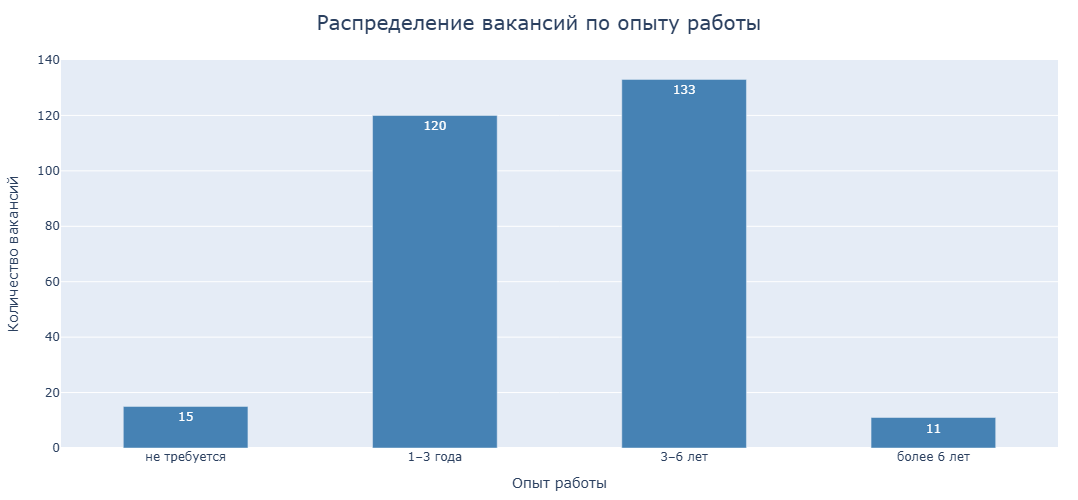

На основе анализа 68 вакансий, где указана зарплата, мы оценили типичные границы предложений на рынке труда
(т.р. после удержания налога):
Опыт работы          Минимум      Среднее     Максимум     Диапазон   Откл от min (%)
-------------------------------------------------------------------------------------
не требуется              76         77.0           78            2               2.6
1–3 года                 112        120.0          128           16              14.3
3–6 лет                  150        180.0          210           60              40.0
более 6 лет              174        206.5          239           65              37.4

---
* Минимум/максимум - типичная нижняя/верхняя граница (медиана значений "от/до").
  Откл от min (%) - относительное отклонение максимума от минимума.


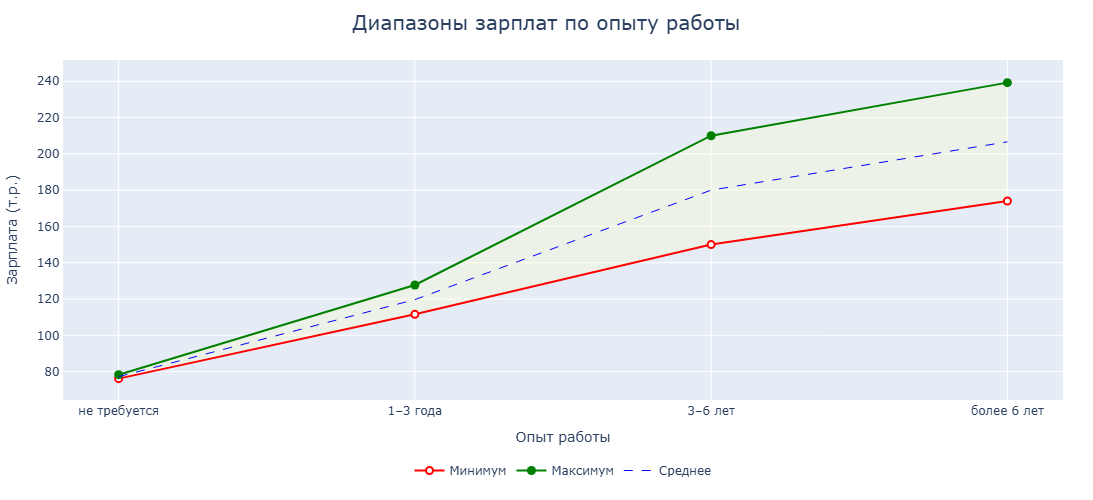


Основные навыки, которые указаны в вакансиях:


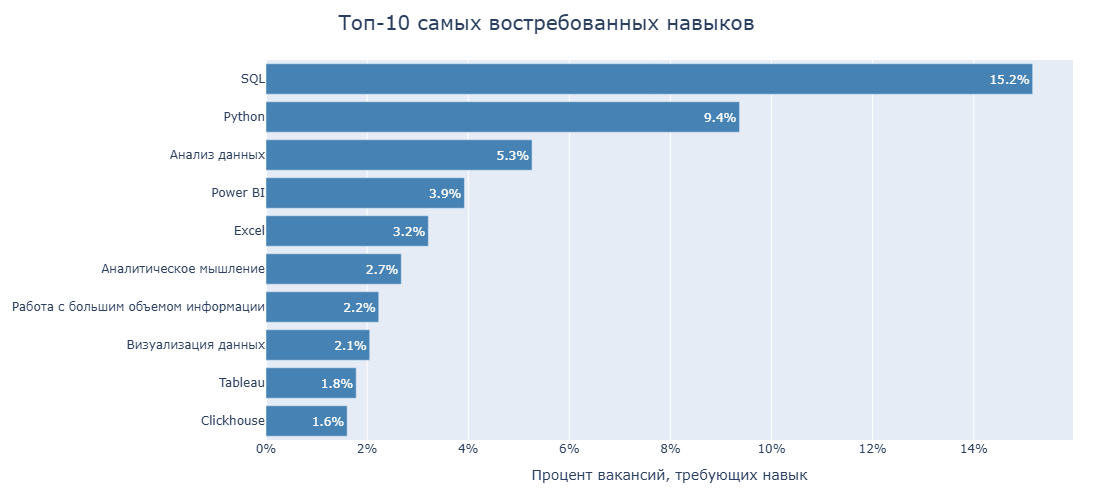


Формат работы, который предлагают работодатели:


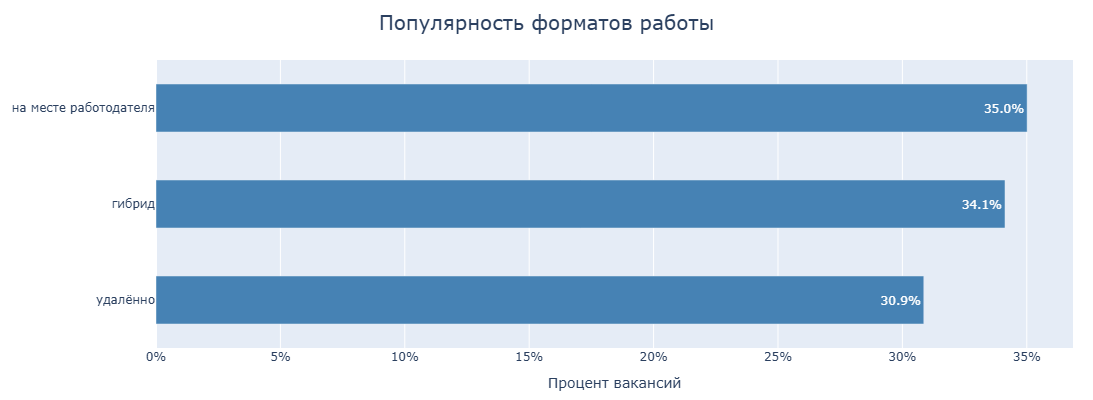

In [9]:
if __name__ == "__main__":
    city = input("Введите название города:")
    print_report(city)